# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [2]:
# Библиотеки

def line():
    print('----------------------------------')
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

# Загрузка данных

In [3]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv') # Данные об электродах
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv') # Данные о подаче сыпучих материалов (объём)
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv') # Данные о подаче сыпучих материалов (время)
gas = pd.read_csv('/datasets/final_steel/data_gas.csv') # Дданные о продувке сплава газом
temp = pd.read_csv('/datasets/final_steel/data_temp.csv') # Результаты измерения температуры
wire = pd.read_csv('/datasets/final_steel/data_wire.csv') # Данные о проволочных материалах (объём)
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') # Данные о проволочных материалах (время)

mass_datas = [arc, bulk, bulk_time, gas, temp, wire, wire_time]

In [4]:
for element in mass_datas:
    display(element)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# План работы

<b>Таблица arc </b>

1. Добавить фичу в виде: Сколько времени было потрачено на нагрев (в минутах) суммарно для каждой партии;
2. Убрать дату из данных;
3. Сгруппировать данные по столбцу key (sum);
4. Обучить модель с реактивной мощностью и без нее т.к реактивная мощость никаким образом не влият на сам нагрев, это то, что отдается обратно в сеть (вредная мощность). Но коллинеарность между активной и реактивной мощностью отсутствует и поэтому тут все спорно, надо будет пробовать;
5. Найти полную мощность;
6. Добавить время нагрева в секундах.

<b>Таблица bulk</b> 
    
    1. Насколько я понимаю каждый столбец этой таблицы, это тип добавки т.е Bulk 1 это к примеру один хим элемент Bulk 2 уже другой и т.д поэтому если мы ничего из этого не добавили значит ставим 0;
    2. В качестве фичи добавить суму всех добавленных составов.
    

<b>Таблица bulk_time</b>
    
    Считаю что это абсолютно бесполезная информация. Важнее то сколько добавили а не когда.
    

<b>Таблица gas</b>
    
    Таблица gas.
    
<b>Таблица temp</b>

    1. Тут мы должны брать последний замер каждой партии т.к. он нас и интересует, если видим Nan -> выкидываем партию.
    2. Добавить в качестве фичи первоначальную температуру
    
<b>Таблица wire</b>

    Поступаем также как и с bulk.
    
<b>Таблица wire_time</b>

    Считаю что это абсолютно бесполезная информация.
    
<b>Итог</b>

    Объединяем все, что получилось

# Предобработка данных

In [5]:
def check(df):
    print(df.info())
    line()
    print('Количество дубликатов:', df.duplicated().sum())
    line()
    print('Количество пропусков:')
    print(df.isnull().sum())

## Таблица arc

In [6]:
check(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
----------------------------------
Количество дубликатов: 0
----------------------------------
Количество пропусков:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


In [7]:
# Таблица arc работа с датой

arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')

display(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [8]:
# Добавление фитч (время нагрева и полная мощность)

arc['difference_seconds'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.seconds
arc['full_power'] = (arc['Активная мощность'] ** 2 + arc['Реактивная мощность'] ** 2) ** (1 / 2)

In [9]:
# Мы получили мультиколлинеарность между актив. мощ. и временем а также реактив. мощ. и полной мощ. что закономерно
# по сути мы просто переработали признаки для модели сохраняя связь между предыдущими. Избавимся от дат и мощностей

display(arc.corr())

arc = arc.drop(['Конец нагрева дугой', 'Начало нагрева дугой', 'Активная мощность', 'Реактивная мощность'], axis = 1)

,key,Активная мощность,Реактивная мощность,difference_seconds,full_power
key,1.000000,-0.021382,-0.004396,-0.018363,0.003225
Активная мощность,-0.021382,1.000000,0.054437,0.974128,0.082691
Реактивная мощность,-0.004396,0.054437,1.000000,0.056587,-0.990321
difference_seconds,-0.018363,0.974128,0.056587,1.000000,0.079838
full_power,0.003225,0.082691,-0.990321,0.079838,1.000000


In [10]:
group_arc = arc.groupby('key').sum().reset_index()
display(group_arc)

,key,difference_seconds,full_power
0,1,1098,5.826395
1,2,811,3.649216
2,3,655,2.989534
3,4,741,3.814962
4,5,869,4.035758
...,...,...,...
3209,3237,909,4.844982
3210,3238,546,2.696542
3211,3239,1216,5.611883
3212,3240,839,3.891856


Комментарий: Типы данных приведены к соответствующим, проведена проверка на дубликаты, пропуски, устранена мультиколлинеарность. Созданы фичи непосредственно связанные с первичными данными, а также произведена группировка по полю key

## Таблица bulk и wire

In [11]:
check(bulk)
line()
check(wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
----------------------------------
Количество дубликатов: 0
----------------------------------
Количество пропусков:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
B

In [12]:
# Заменим пропуски на нули т.к они будут соответствовать тому, что в данной партии не было никаких добавлений

bulk = bulk.fillna(0)
wire = wire.fillna(0)

display(bulk)
display(wire)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Найдем общее количество добавлений для каждой партии в качестве фичи

bulk['sum_bulk'] = bulk.iloc[:,1:].sum(axis = 1)
wire['sum_wire'] = wire.iloc[:,1:].sum(axis = 1)

display(bulk)
display(wire)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400


## Таблица temp

In [14]:
# Исследование на количество пропусков и количество измерений
check(temp)
line()

count_bath = pd.DataFrame(temp['key'].value_counts())
print('Количество измерений в партии: \n', count_bath)

display(temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
----------------------------------
Количество дубликатов: 0
----------------------------------
Количество пропусков:
key                0
Время замера       0
Температура     2901
dtype: int64
----------------------------------
Количество измерений в партии: 
       key
44     16
1214   16
1513   16
46     16
1689   15
...   ...
1106    2
1424    2
3156    2
279     1
195     1

[3216 rows x 1 columns]


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


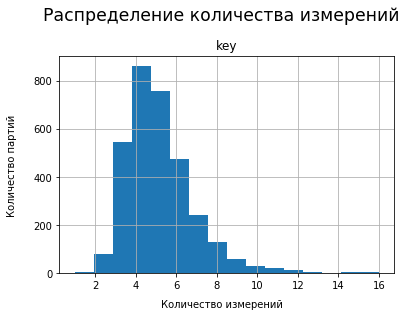

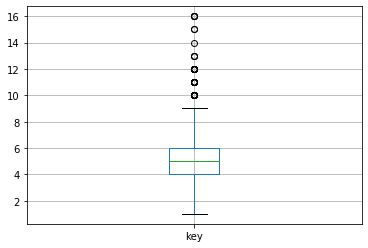

In [15]:
fig, axes = plt.subplots(sharex=True, sharey=True)

count_bath.hist('key', bins = 16, ax=axes)

plt.suptitle('Распределение количества измерений', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.004, 'Количество измерений', ha='center')
fig.text(0.004, 0.5, 'Количество партий', va='center', rotation='vertical')
plt.show()


count_bath.boxplot()
plt.show()

Комментарий: Исходя из того, что мы получили нам необходимо во первых удалить партии с незаконченными измерениями температуры (NaN) а также партии которые содержат одно измерение. Исходя из графиков можно сказать что в среднем для достижения нужной температуры требуется от 4 до 6 замеров, boxplot показал нам выбросы выше 10 измерений, но отсекать эти данные мы пока что не будем, а если придется ввести корректировки, то при обучении модели попробуем убрать эти данные

In [16]:
nan_keys = temp.loc[temp['Температура'].isnull()]['key'].unique()

temp = temp[~temp['key'].isin(nan_keys)].reset_index(drop = True)
temp = temp.loc[(temp['key'] != 195) & (temp['key'] != 279)]

display(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [17]:
# Создадим фичу: количество измерений

count_bath_new = pd.DataFrame(temp['key'].value_counts()).sort_index().reset_index()
display(count_bath_new)

,index,key
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2
...,...,...
2470,2495,3
2471,2496,4
2472,2497,2
2473,2498,5


In [18]:
last_temp = pd.DataFrame()
first_temp = pd.DataFrame()
unique_key = temp['key'].unique()

for key in unique_key:
    last_temp = last_temp.append(temp.loc[temp['key'] == key].tail(1), ignore_index = True)
    first_temp = first_temp.append(temp.loc[temp['key'] == key].head(1), ignore_index = True)
    
full_temp = last_temp.merge(first_temp,  how = 'inner', on = 'key')

In [19]:
full_temp['count_bath'] = count_bath_new['key']
full_temp = full_temp.drop(['Время замера_x', 'Время замера_y'], axis = 1)

full_temp.columns = ['key', 'finish_temp', 'start_temp', 'count_bath']

display(full_temp)

,key,finish_temp,start_temp,count_bath
0,1,1613.0,1571.0,5
1,2,1602.0,1581.0,6
2,3,1599.0,1596.0,5
3,4,1625.0,1601.0,3
4,5,1602.0,1576.0,2
...,...,...,...,...
2470,2495,1591.0,1570.0,3
2471,2496,1591.0,1554.0,4
2472,2497,1589.0,1571.0,2
2473,2498,1594.0,1591.0,5


# Объединение таблиц

In [20]:
gas.columns = ['key', 'gas']

merge_arc_temp = full_temp.merge(group_arc,  how = 'left', on = 'key')
merge_arc_temp_wire = merge_arc_temp.merge(wire,  how = 'left', on = 'key')
merge_arc_temp_wire_bulk = merge_arc_temp_wire.merge(bulk,  how = 'left', on = 'key')
merge_arc_temp_wire_bulk_gas = merge_arc_temp_wire_bulk.merge(gas,  how = 'left', on = 'key')

full_data = merge_arc_temp_wire_bulk_gas

In [21]:
# После объединения появились пропуски

display(full_data)
display(full_data.isnull().sum())

,key,finish_temp,start_temp,count_bath,difference_seconds,full_power,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
0,1,1613.0,1571.0,5,1098,5.826395,60.059998,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,2,1602.0,1581.0,6,811,3.649216,96.052315,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,3,1599.0,1596.0,5,655,2.989534,91.160157,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,4,1625.0,1601.0,3,741,3.814962,89.063515,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,5,1602.0,1576.0,2,869,4.035758,89.238236,9.11456,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1591.0,1570.0,3,723,3.986869,89.150879,0.00000,0.0,0.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,7.125735
2471,2496,1591.0,1554.0,4,940,5.057033,114.179527,0.00000,0.0,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,9.412616
2472,2497,1589.0,1571.0,2,569,2.885017,94.086723,9.04800,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,6.271699
2473,2498,1594.0,1591.0,5,750,4.143749,118.110717,0.00000,0.0,0.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,733.0,14.953657


key                     0
finish_temp             0
start_temp              0
count_bath              0
difference_seconds      0
full_power              0
Wire 1                103
Wire 2                103
Wire 3                103
Wire 4                103
Wire 5                103
Wire 6                103
Wire 7                103
Wire 8                103
Wire 9                103
sum_wire              103
Bulk 1                 68
Bulk 2                 68
Bulk 3                 68
Bulk 4                 68
Bulk 5                 68
Bulk 6                 68
Bulk 7                 68
Bulk 8                 68
Bulk 9                 68
Bulk 10                68
Bulk 11                68
Bulk 12                68
Bulk 13                68
Bulk 14                68
Bulk 15                68
sum_bulk               68
gas                     2
dtype: int64

Комментарий: По технологическому процессу мы явно видим что у нас идет нагревание, добавление хим составов, и продувка газом, после объединения таблиц, мы видим что некоторые партии не соответствуют самому технологическому процессу а это значит что это в какой-то мере брак, поэтому удаляем пропуски.

In [22]:
# Подтверждение законности удаления

bad_data = full_data.loc[full_data['sum_wire'].isnull() | full_data['sum_bulk'].isnull() | full_data['gas'].isnull()]

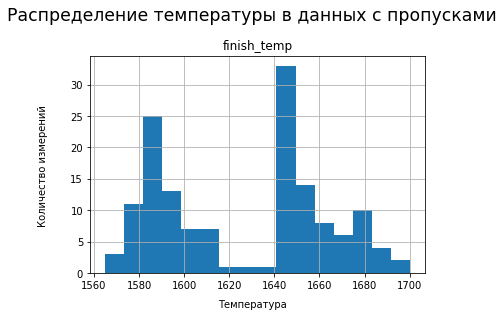

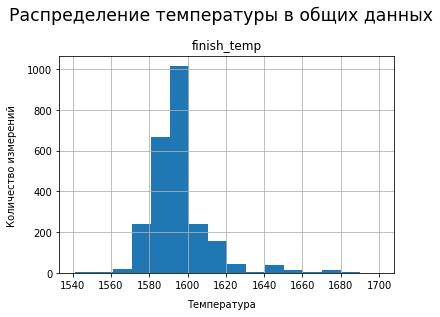

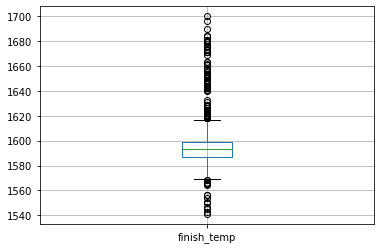

In [23]:
fig, axes = plt.subplots(sharex=True, sharey=True)
bad_data.hist('finish_temp', bins = 16, ax=axes)
plt.suptitle('Распределение температуры в данных с пропусками', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.004, 'Температура', ha='center')
fig.text(0.004, 0.5, 'Количество измерений', va='center', rotation='vertical')
plt.show()

fig, axes = plt.subplots(sharex=True, sharey=True)
full_data.hist('finish_temp', bins = 16, ax=axes)
plt.suptitle('Распределение температуры в общих данных', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.004, 'Температура', ha='center')
fig.text(0.004, 0.5, 'Количество измерений', va='center', rotation='vertical')
plt.show()

full_data.boxplot('finish_temp')
plt.show()

Комментарий: Исходя из приведенных гистограмм и boxplot видно, что данные с пропусками, это данные с температурой далеко отклоненной от средней температуры всего датасета, являющиеся выбросами. Т.к таких данных не так много, удалим их

In [24]:
full_data = full_data.dropna()
display(full_data.isnull().sum())

key                   0
finish_temp           0
start_temp            0
count_bath            0
difference_seconds    0
full_power            0
Wire 1                0
Wire 2                0
Wire 3                0
Wire 4                0
Wire 5                0
Wire 6                0
Wire 7                0
Wire 8                0
Wire 9                0
sum_wire              0
Bulk 1                0
Bulk 2                0
Bulk 3                0
Bulk 4                0
Bulk 5                0
Bulk 6                0
Bulk 7                0
Bulk 8                0
Bulk 9                0
Bulk 10               0
Bulk 11               0
Bulk 12               0
Bulk 13               0
Bulk 14               0
Bulk 15               0
sum_bulk              0
gas                   0
dtype: int64

# Исследование на наличие выбросов в данных

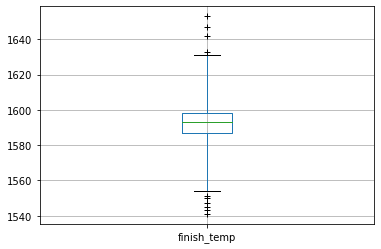

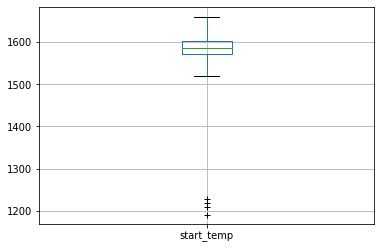

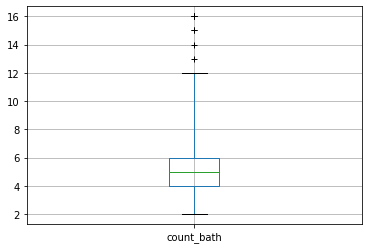

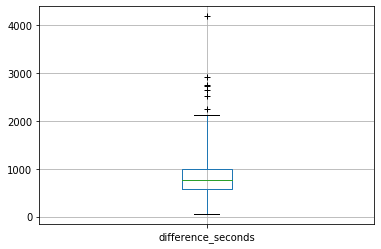

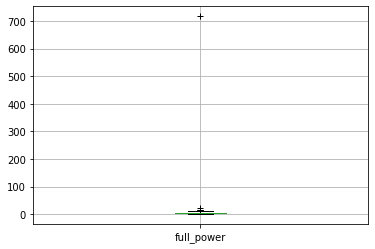

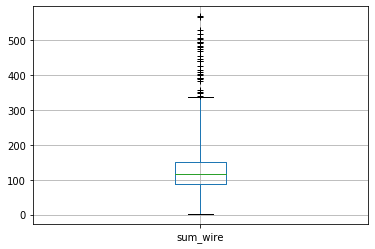

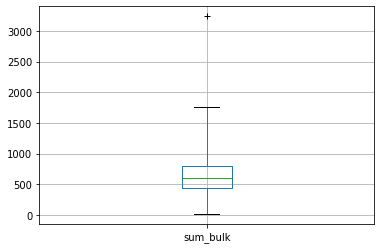

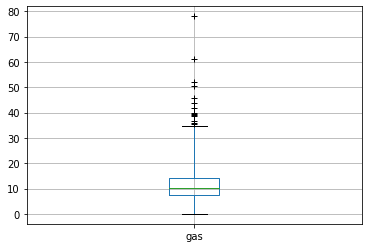

In [25]:
# Выполним проверку на выбросы полного датасета и избавимся от явных выбросов (3 квартиль)

def check_emissions():
    name_columns_check = ['finish_temp', 'start_temp', 'count_bath', 'difference_seconds', 'full_power', 'sum_wire', 'sum_bulk', 'gas']

    for name in name_columns_check:
        full_data.boxplot(name, sym='+', vert=True, whis=3)
        plt.show()
        
check_emissions()

In [26]:
full_data = (full_data.loc[(full_data['count_bath'] < 12) & 
                           (full_data['difference_seconds'] < 2100) & 
                           (full_data['full_power'] < 11) &
                           (full_data['sum_wire'] < 335) & 
                           (full_data['gas'] < 33) &
                           (full_data['finish_temp'] < 1631) &
                           (full_data['finish_temp'] > 1565) &
                           (full_data['start_temp'] > 1370)]
            )

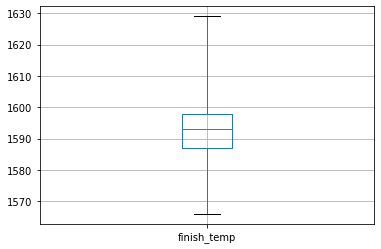

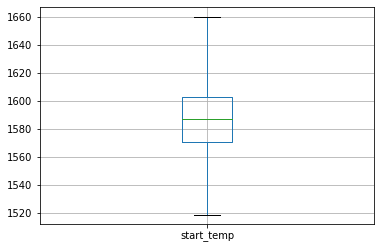

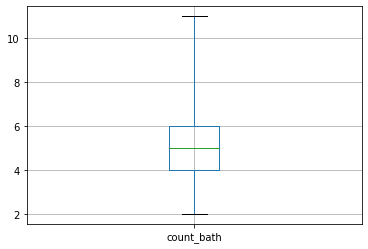

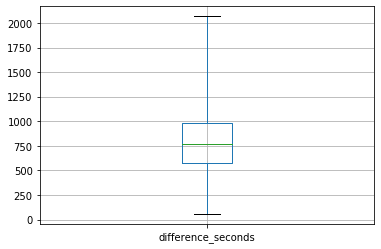

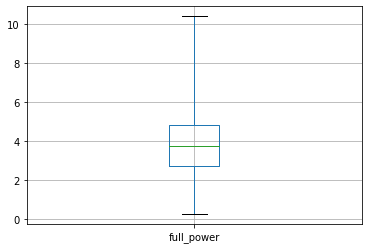

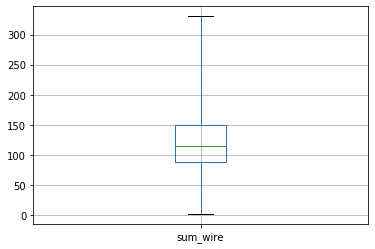

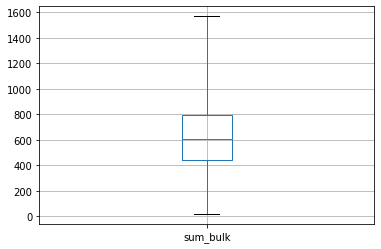

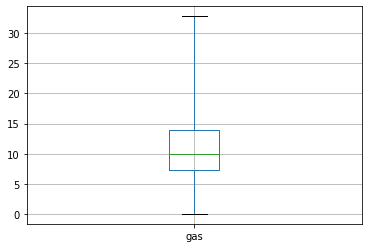

In [27]:
check_emissions()

In [28]:
pd.set_option('display.max_columns', None)

display(full_data)
full_data.corr()

,key,finish_temp,start_temp,count_bath,difference_seconds,full_power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
0,1,1613.0,1571.0,5,1098,5.826395,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,29.749986
1,2,1602.0,1581.0,6,811,3.649216,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,12.555561
2,3,1599.0,1596.0,5,655,2.989534,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,28.554793
3,4,1625.0,1601.0,3,741,3.814962,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,18.841219
4,5,1602.0,1576.0,2,869,4.035758,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1591.0,1570.0,3,723,3.986869,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,7.125735
2471,2496,1591.0,1554.0,4,940,5.057033,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,9.412616
2472,2497,1589.0,1571.0,2,569,2.885017,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,6.271699
2473,2498,1594.0,1591.0,5,750,4.143749,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,733.0,14.953657


,key,finish_temp,start_temp,count_bath,difference_seconds,full_power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
key,1.000000,-0.084353,-0.024581,-0.056502,-0.015073,-0.001109,-0.019839,0.055923,-0.007693,0.012169,NaN,-0.005125,NaN,-0.025972,0.020089,0.016440,-0.078098,-0.008072,-0.011306,-0.033208,0.034106,0.004857,0.034839,0.015667,-0.029902,0.064901,0.033144,0.031687,-0.016473,-0.094449,-0.050061,-0.025785,-0.029221
finish_temp,-0.084353,1.000000,0.320726,0.142978,0.293312,0.286097,0.315886,-0.232508,0.049771,0.054812,NaN,-0.013133,NaN,-0.011124,-0.020366,0.120336,-0.053855,0.050761,-0.042738,0.198935,0.018497,-0.201240,0.065879,-0.028769,-0.016879,0.069041,-0.117101,0.247727,-0.031640,0.073044,0.259525,0.224373,0.076033
start_temp,-0.024581,0.320726,1.000000,0.195514,-0.431847,-0.479701,0.285089,-0.108646,0.075852,0.065203,NaN,-0.037557,NaN,-0.012410,-0.009337,0.171223,0.048492,0.075993,-0.118138,0.161806,0.045266,-0.137222,0.051447,-0.012019,-0.016281,0.037733,-0.117093,-0.087642,0.023626,-0.179601,-0.062937,-0.135888,0.008044
count_bath,-0.056502,0.142978,0.195514,1.000000,0.329956,0.297350,0.200196,0.042253,0.010609,0.018217,NaN,0.001263,NaN,-0.003864,0.005612,0.195211,0.062927,0.010347,0.028356,0.012544,0.039130,0.076515,0.031640,-0.011527,-0.011183,-0.013785,0.030990,0.107045,0.041773,0.110309,0.024262,0.133399,0.270823
difference_seconds,-0.015073,0.293312,-0.431847,0.329956,1.000000,0.980564,0.062414,0.044988,-0.006816,0.010282,NaN,0.020578,NaN,0.005160,0.010991,0.084177,0.064400,-0.006662,0.105959,-0.025884,0.004745,0.131339,0.030062,-0.011660,-0.000194,0.002052,0.080388,0.479151,0.029413,0.450455,0.321244,0.546488,0.365197
full_power,-0.001109,0.286097,-0.479701,0.297350,0.980564,1.000000,0.043865,0.044482,0.000435,0.017746,NaN,0.036577,NaN,0.013267,0.006564,0.071957,0.062403,0.000638,0.111581,-0.030565,0.003238,0.120035,0.036085,-0.010744,0.006965,0.010686,0.075363,0.490582,0.021909,0.446251,0.349899,0.559038,0.341433
Wire 1,-0.019839,0.315886,0.285089,0.200196,0.062414,0.043865,1.000000,-0.107760,-0.100839,-0.086081,NaN,-0.084501,NaN,0.010529,-0.003626,0.745414,0.058413,-0.100907,0.017926,0.320666,0.028824,-0.261215,-0.069826,0.036565,0.016542,0.065206,-0.126116,0.176291,0.031047,-0.079629,0.117612,0.122576,0.147276
Wire 2,0.055923,-0.232508,-0.108646,0.042253,0.044988,0.044482,-0.107760,1.000000,-0.021816,-0.019024,NaN,-0.047638,NaN,0.059367,0.169299,0.539997,-0.036428,-0.022271,0.081183,-0.270129,-0.002456,0.205552,-0.013434,0.021146,0.056262,-0.103965,0.076898,-0.119381,0.009495,0.014487,-0.102892,-0.090110,0.090063
Wire 3,-0.007693,0.049771,0.075852,0.010609,-0.006816,0.000435,-0.100839,-0.021816,1.000000,0.856050,NaN,0.359524,NaN,-0.002804,-0.003601,0.061163,0.100728,0.999117,-0.026620,0.016601,0.217484,-0.016872,0.703256,-0.000896,-0.002839,-0.010376,-0.007998,-0.058394,-0.003045,-0.081975,-0.061092,0.027347,0.066337
Wire 4,0.012169,0.054812,0.065203,0.018217,0.010282,0.017746,-0.086081,-0.019024,0.856050,1.000000,NaN,0.344455,NaN,-0.002388,-0.003067,0.066963,0.067091,0.866034,-0.022727,0.017846,0.204013,-0.014669,0.805995,-0.000763,-0.002418,-0.008836,-0.006859,-0.049957,-0.002593,-0.070066,-0.052290,0.040142,0.059640


In [29]:
# Data без мультиколлинеарности (можешь посмотреть на точность в LinearRegression)

full_data_clean = full_data.drop(['Bulk 12', 'Bulk 15', 'Bulk 9', 'Bulk 7', 'Wire 4', 'Wire 5', 'Wire 1', 'Wire 7', 'difference_seconds', 'Bulk 2'], axis = 1)
display(full_data_clean.corr())

,key,finish_temp,start_temp,count_bath,full_power,Wire 2,Wire 3,Wire 6,Wire 8,Wire 9,sum_wire,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 8,Bulk 10,Bulk 11,Bulk 13,Bulk 14,sum_bulk,gas
key,1.000000,-0.084353,-0.024581,-0.056502,-0.001109,0.055923,-0.007693,-0.005125,-0.025972,0.020089,0.016440,-0.078098,-0.011306,-0.033208,0.034106,0.004857,0.015667,0.064901,0.033144,-0.016473,-0.094449,-0.025785,-0.029221
finish_temp,-0.084353,1.000000,0.320726,0.142978,0.286097,-0.232508,0.049771,-0.013133,-0.011124,-0.020366,0.120336,-0.053855,-0.042738,0.198935,0.018497,-0.201240,-0.028769,0.069041,-0.117101,-0.031640,0.073044,0.224373,0.076033
start_temp,-0.024581,0.320726,1.000000,0.195514,-0.479701,-0.108646,0.075852,-0.037557,-0.012410,-0.009337,0.171223,0.048492,-0.118138,0.161806,0.045266,-0.137222,-0.012019,0.037733,-0.117093,0.023626,-0.179601,-0.135888,0.008044
count_bath,-0.056502,0.142978,0.195514,1.000000,0.297350,0.042253,0.010609,0.001263,-0.003864,0.005612,0.195211,0.062927,0.028356,0.012544,0.039130,0.076515,-0.011527,-0.013785,0.030990,0.041773,0.110309,0.133399,0.270823
full_power,-0.001109,0.286097,-0.479701,0.297350,1.000000,0.044482,0.000435,0.036577,0.013267,0.006564,0.071957,0.062403,0.111581,-0.030565,0.003238,0.120035,-0.010744,0.010686,0.075363,0.021909,0.446251,0.559038,0.341433
Wire 2,0.055923,-0.232508,-0.108646,0.042253,0.044482,1.000000,-0.021816,-0.047638,0.059367,0.169299,0.539997,-0.036428,0.081183,-0.270129,-0.002456,0.205552,0.021146,-0.103965,0.076898,0.009495,0.014487,-0.090110,0.090063
Wire 3,-0.007693,0.049771,0.075852,0.010609,0.000435,-0.021816,1.000000,0.359524,-0.002804,-0.003601,0.061163,0.100728,-0.026620,0.016601,0.217484,-0.016872,-0.000896,-0.010376,-0.007998,-0.003045,-0.081975,0.027347,0.066337
Wire 6,-0.005125,-0.013133,-0.037557,0.001263,0.036577,-0.047638,0.359524,1.000000,-0.006026,-0.007739,0.085865,0.071849,0.035318,-0.040778,0.075600,-0.006084,-0.001927,-0.011079,0.007431,-0.006545,-0.002679,0.050888,0.012897
Wire 8,-0.025972,-0.011124,-0.012410,-0.003864,0.013267,0.059367,-0.002804,-0.006026,1.000000,-0.005612,0.128662,-0.018437,0.003192,0.014014,-0.006968,-0.026845,0.337231,-0.016171,-0.012553,-0.004746,0.035920,-0.028798,0.086809
Wire 9,0.020089,-0.020366,-0.009337,0.005612,0.006564,0.169299,-0.003601,-0.007739,-0.005612,1.000000,0.162192,0.021830,-0.006383,-0.054021,-0.008950,-0.006756,-0.001794,-0.020770,-0.016122,-0.006096,0.047736,-0.030508,0.019218


Комментарий: Теперь после полной предобработки данных можно обучать модель. Также я убрал все мультиколлинеарные столбцы и получил на регрессии 5.670286869798782, но катбуст просел. Но учитывая то насколько быстро учится регрессия, я бы предпочел выбрать ее как лучшую модель. Но тут уже на усмотрение. Нужно быстро -> full_data_clean + LinearRegression, нужно точно -> full_data + CatBoostRegressor.

# Обучение модели

## Подготовка данных

In [30]:
# Выполним разделение выборки на обучающу валидационную и тестовую

features = full_data.drop(['finish_temp', 'key', 'difference_seconds'], axis = 1)
target = full_data['finish_temp']

# Получение пропорции 60:40

features_train, features_40, target_train, target_40 = train_test_split(
    features, target, test_size = 0.40, random_state = 12345)

# Разделение 40 % на две части

features_valid, features_test, target_valid, target_test = train_test_split(
    features_40, target_40, test_size = 0.50, random_state = 12345)

In [31]:
# Проверим размерность

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

line()

print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(1344, 30)
(448, 30)
(448, 30)
----------------------------------
(1344,)
(448,)
(448,)


In [32]:
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Масштабирование признаков

numeric = features.columns

scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [33]:
display(features_train)

,start_temp,count_bath,full_power,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,gas
6,0.471429,0.333333,0.274616,0.395246,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302113,0.0,0.0,0.000000,0.416370,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.239156,0.000000,0.373464,0.380247,0.392258,0.281946
2322,0.357143,0.333333,0.964054,0.493134,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378428,0.0,0.0,0.000000,0.099644,0.0,0.000000,0.0,0.0,0.0,0.612245,0.00000,0.305979,0.000000,0.471744,0.387654,0.457419,0.416934
1481,0.292857,0.111111,0.362011,0.569102,0.189638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547970,0.0,0.0,0.201900,0.000000,0.0,0.000000,0.0,0.0,0.0,0.564626,0.00000,0.000000,0.000000,0.000000,0.000000,0.096129,0.231913
845,0.292857,0.222222,0.526788,0.492895,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378241,0.0,0.0,0.627078,0.341637,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.479484,0.000000,0.555283,0.503704,0.761290,0.422239
2007,0.242857,0.333333,0.492835,0.303345,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230465,0.0,0.0,0.000000,0.000000,0.0,0.406685,0.0,0.0,0.0,0.000000,0.00000,0.062134,0.000000,0.624079,0.135802,0.315484,0.416508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,0.550000,0.777778,0.672429,0.335387,0.601825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605536,0.0,0.0,0.000000,0.000000,0.0,0.325905,0.0,0.0,0.0,0.000000,0.00000,0.187573,0.764706,0.000000,0.269136,0.337419,0.423656
609,0.471429,0.333333,0.358639,0.422912,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323682,0.0,0.0,0.000000,0.153025,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.237984,0.000000,0.250614,0.501235,0.343226,0.113575
442,0.521429,0.111111,0.318040,0.403672,0.076083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352940,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.631450,0.000000,0.153548,0.197795
2407,0.307143,0.222222,0.360866,0.342606,0.162920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.355846,0.0,0.0,0.054632,0.000000,0.0,0.161560,0.0,0.0,0.0,0.000000,0.15016,0.181712,0.000000,0.336609,0.503704,0.390323,0.240393


## LinearRegression

In [34]:
# Для замера времени обучения и предсказания

results = [[],[],[],[]]

In [35]:
model_LR = LinearRegression()

start_time_fit = time.time()
model_LR.fit(features_train, target_train)
results[0].append(time.time() - start_time_fit)

predict = model_LR.predict(features_valid)
print('MAE:', mean_absolute_error(target_valid, predict))

MAE: 5.991868904658726


In [36]:
start_time_predict = time.time()
predict = model_LR.predict(features_test)
results[0].append(time.time() - start_time_predict)

results[0].append(mean_absolute_error(target_test, predict))

print('MAE:', mean_absolute_error(target_test, predict))

MAE: 7.373146874564035


### Важность факторов LinearRegression

In [37]:
intercept = model_LR.intercept_
features = pd.DataFrame(model_LR.coef_, features_train.columns, columns=['coefficient'])
features.coefficient = features.coefficient.abs()

In [38]:
stdevs = []
for i in features_train.columns:
    stdev = full_data[i].std()
    stdevs.append(stdev)
    
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_normalized'] = 100 * features['importance'] / features['importance'].max()
features = features.sort_values(by=['importance'], ascending = False).drop(['coefficient', 'stdev', 'importance_normalized'], axis = 1)

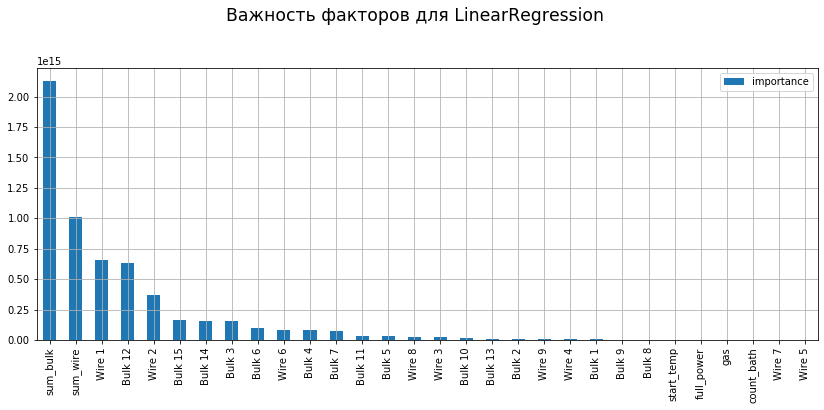

In [39]:
features.plot(kind='bar', grid = True, figsize=(14, 5))
plt.suptitle('Важность факторов для LinearRegression', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

## CatBoostRegressor

In [ ]:
grid_values = {'learning_rate': [0.05, 0.06, 0.07], 'depth': [3, 4], 'l2_leaf_reg': [8, 9]}

model_CR = GridSearchCV(CatBoostRegressor(), param_grid=grid_values)
model_CR.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0:	learn: 10.4802394	total: 48ms	remaining: 48s
1:	learn: 10.4262555	total: 48.9ms	remaining: 24.4s
2:	learn: 10.3541065	total: 49.9ms	remaining: 16.6s
3:	learn: 10.2797923	total: 50.5ms	remaining: 12.6s
4:	learn: 10.1835754	total: 52.1ms	remaining: 10.4s
5:	learn: 10.0786458	total: 53.5ms	remaining: 8.86s
6:	learn: 10.0331259	total: 55.3ms	remaining: 7.84s
7:	learn: 9.9609599	total: 57.2ms	remaining: 7.09s
8:	learn: 9.8764394	total: 59.1ms	remaining: 6.51s
9:	learn: 9.8176341	total: 60.9ms	remaining: 6.03s
10:	learn: 9.7460683	total: 63.1ms	remaining: 5.67s
11:	learn: 9.7035281	total: 66.4ms	remaining: 5.47s
12:	learn: 9.6322657	total: 69ms	remaining: 5.24s
13:	learn: 9.5727156	total: 71ms	remaining: 5s
14:	learn: 9.5291068	total: 75.7ms	remaining: 4.97s
15:	learn: 9.4572303	total: 77ms	remaining: 4.73s
16:	learn: 9.4083168	total: 141ms	remaining: 8.16s
17:	learn: 9.3405258	total: 143ms	remaining: 7.82s
18:	learn: 9.3015042	total: 145ms	remaining: 7.49s
19:	learn: 9.2342525	total: 147

In [ ]:
print(model_CR.best_params_)

In [ ]:
# Докрутим руками

model_CR = CatBoostRegressor(depth = 3, l2_leaf_reg = 9, learning_rate = 0.071)

start_time_fit = time.time()
model_CR.fit(features_train, target_train)
results[1].append(time.time() - start_time_fit)

predict = model_CR.predict(features_valid)
print('MAE:', mean_absolute_error(target_valid, predict))

In [ ]:
start_time_predict = time.time()
predict = model_CR.predict(features_test)
results[1].append(time.time() - start_time_predict)

results[1].append(mean_absolute_error(target_test, predict))

print('MAE:', mean_absolute_error(target_test, predict))

### Важность факторов CatBoost

In [ ]:
df_feature_importance = pd.DataFrame(model_CR.feature_importances_, index=features_test.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)

df_feature_importance.plot(kind='bar', grid = True, figsize=(14, 5))
plt.suptitle('Важность факторов для CatBoost', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

## LGBMRegressor

In [ ]:
model_LGBM = LGBMRegressor()

start_time_fit = time.time()
model_LGBM.fit(features_train, target_train)
results[2].append(time.time() - start_time_fit)

predict = model_LGBM.predict(features_valid)
print('MAE:', mean_absolute_error(target_valid, predict))

In [ ]:
start_time_predict = time.time()
predict = model_LGBM.predict(features_test)
results[2].append(time.time() - start_time_predict)

results[2].append(mean_absolute_error(target_test, predict))

print('MAE:', mean_absolute_error(target_test, predict))

### Важность факторов LGBM

In [ ]:
df_feature_importance = pd.DataFrame(model_LGBM.feature_importances_, index=features_test.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)

df_feature_importance.plot(kind='bar', grid = True, figsize=(14, 5))
plt.suptitle('Важность факторов для LGBM', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

## XGBRegressor

In [ ]:
model_XGB = XGBRegressor()

start_time_fit = time.time()
model_XGB.fit(features_train, target_train)
results[3].append(time.time() - start_time_fit)

predict = model_XGB.predict(features_valid)
print('MAE:', mean_absolute_error(target_valid, predict))

In [ ]:
start_time_predict = time.time()
predict = model_XGB.predict(features_test)
results[3].append(time.time() - start_time_predict)

results[3].append(mean_absolute_error(target_test, predict))

print('MAE:', mean_absolute_error(target_test, predict))

In [ ]:
df_feature_importance = pd.DataFrame(model_XGB.feature_importances_, index=features_test.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)

df_feature_importance.plot(kind='bar', grid = True, figsize=(14, 5))
plt.suptitle('Важность факторов для XGB', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

In [ ]:
results = pd.DataFrame(results)
results.columns = ['Time_fit', 'Time_predict', 'MAE']
results.index = ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor', 'XGBRegressor']

display(results)

# Вывод

1. Данные исследованы и выполнена предобработка данных;
2. Все таблицы соеденены в одну;
3. Пропуски, выбросы и нулевые значения удалены;
4. Получено две таблицы с мультиколлинеарными столбцами и без них;
5. Модели обучены;
6. Самая быстрая и точная модель LinearRegression на full_data_clean;
7. Самая точная модель CatBoostRegressor на full_data.

<b>На что стоит обратить внимание</b>

1. Фичи важны, но не все;
2. Выбросы все портят;
3. Разные модели по разному реагируют на разный датасет.

<b> Комментарий: Важность для каждой модели добавлена. Что интересного можно сказать: </b>

1. Ну во первых это то что в большинстве случаев у нас можно отбрасывать некоторые добавки, что это за добавки не мне разбираться, также и нагрев важен только первыми электродами даже можно сказать первыми тремя;
2. Самое крутое, это что все фичи нужны, но только не для линейной регрессии) это радует;
3. У каждой модели свои важные параметры;
4. Линейная регрессия интересная модель, ей газ не важен, мощность, стартовая температура, количество замеров. Для нее только интересна последняя добавка и объем электродов.

# Отчет по решению

## Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана были выполнены, а также удалось с первого раза добыть важные фичи, за исключением времени нагрева т.к данную фичу пришлось убрать из-за корреляции с полной мощностью

## Какие трудности возникли и как вы их преодолели?

Единственная трудность, которая возникла, это понимание того, что важна начальная температура нагрева... Почему-то не подумал об этом сразу и в связи с этим точность была не достаточной для набора максимального балла

## Какие ключевые шаги в решении задачи выделили?

1. Очень важна правильная предобработка;
2. Понимание того, что дата в основном необходима для добывания фич;
3. Преобразование признаков в новые признаки более понятные для моделей;
4. Правильное объединение таблиц;
5. Удаление выбросов;
5. Учет корреляции.

## Какая ваша итоговая модель и какое у неё качество?

Я убрал все мультиколлинеарные столбцы и получил на регрессии 5.670286869798782, но катбуст просел. Но учитывая то насколько быстро учится регрессия, я бы предпочел выбрать ее как лучшую модель. Но тут уже на усмотрение. Нужно быстро -> full_data_clean (данные без мультиколлинеарности) + LinearRegression, нужно точно -> full_data (данные с мультиколлинеарностью) + CatBoostRegressor.

<b>Итоговые значения метрики MAE на тесте:</b>

1. LinearRegression + full_data_clean -> 5.670286869798782;
2. CatBoostRegressor + full_data -> 5.599487743108874.